# 15_BANKSY_style_SIMBA_rankK

In [2]:
%load_ext autoreload
%autoreload 2


import sys
sys.path.insert(1, '../scripts/benchmarking')

In [3]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from src.plot import plot_spatial, palette_celltype, plot_obs_spatial
import pandas as pd
import numpy as np
palette_entity_anno = palette_celltype.copy()
palette_entity_anno['gene'] = "lightgray"
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [4]:
import os
import simba as si
si.__version__

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'1.2'

In [5]:
workdir = 'data/15'
si.settings.set_workdir(workdir)

Saving results in: data/15


In [6]:
si.settings.set_figure_params(
    dpi=80,
    style='white',
    fig_size=[5,5],
    rc={'image.cmap': 'viridis'}
)

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

In [7]:
import anndata as ad
from scipy.sparse import csr_matrix
# from manually added path
from spatial import gen_spatial_graph
from plot import plot_spatial_kernel
import squidpy as sq

# Load data

In [8]:
adata_fn = "/data/pinello/PROJECTS/2025-01-31_CC_Spatial_SIMBA/SIMBA_in_space/data/human_DLPFC/151507.h5ad"
adata = sc.read_h5ad(adata_fn)

In [9]:
from scipy.spatial import cKDTree

# Build the KDTree
coords = adata.obsm['spatial']
tree = cKDTree(coords)

# Query the k+1 nearest neighbors (to exclude the point itself)
k = 10
distances, indices = tree.query(coords, k=k+1)
# Exclude self (first column)
indices = indices[:, 1:]

print(indices)

[[3165 1084 1337 ... 3059 2552 3384]
 [1202 4110  453 ... 3594 1022  784]
 [3334 1706  786 ... 1421 3602 2151]
 ...
 [3352 2148 3810 ... 2521 2492 2637]
 [ 660 3281 3046 ... 1054 1649 2028]
 [1798 2660 3960 ... 1087 3561  443]]


In [10]:
indices.shape

(4221, 10)

In [11]:
rankK_adatas = {}
for rank in range(k):
    k_adata = adata.copy()
    k_adata.X = adata.X[indices[:, rank], :]
    k_adata.var_names = k_adata.var_names + "_r" + str(rank)
    rankK_adatas[rank] = k_adata.copy()

In [12]:
def combine_adatas(adata_CG, K_adata_CG, lambda_val=0.8):
    
    num_neighbors = len(K_adata_CG)
    kn_weight = np.sqrt(1 - lambda_val) / num_neighbors # uniform weight on the neighbors

    tmp_adata_CG = adata_CG.copy()
    tmp_adata_CG.X = tmp_adata_CG.X * lambda_val
    tmp_adata_CG.var['gene_rank'] = -1
    weighted_adatas = [tmp_adata_CG]

    for r, adata in K_adata_CG.items():
        tmp_adata = adata.copy()
        tmp_adata.X = tmp_adata.X * kn_weight
        tmp_adata.var['gene_rank'] = r
        weighted_adatas.append(tmp_adata)

    banksy_adata = ad.concat(weighted_adatas, axis=1)
    banksy_adata.layers['counts'] = csr_matrix(banksy_adata.X)
    return banksy_adata, lambda_val, kn_weight

In [13]:
len(rankK_adatas)

10

In [14]:
banksy_local_adata, lambda_val, kn_weight = combine_adatas(adata, rankK_adatas, lambda_val=0.8)

In [15]:
kn_weight

0.04472135954999579

In [16]:
banksy_local_adata.shape

(4221, 173998)

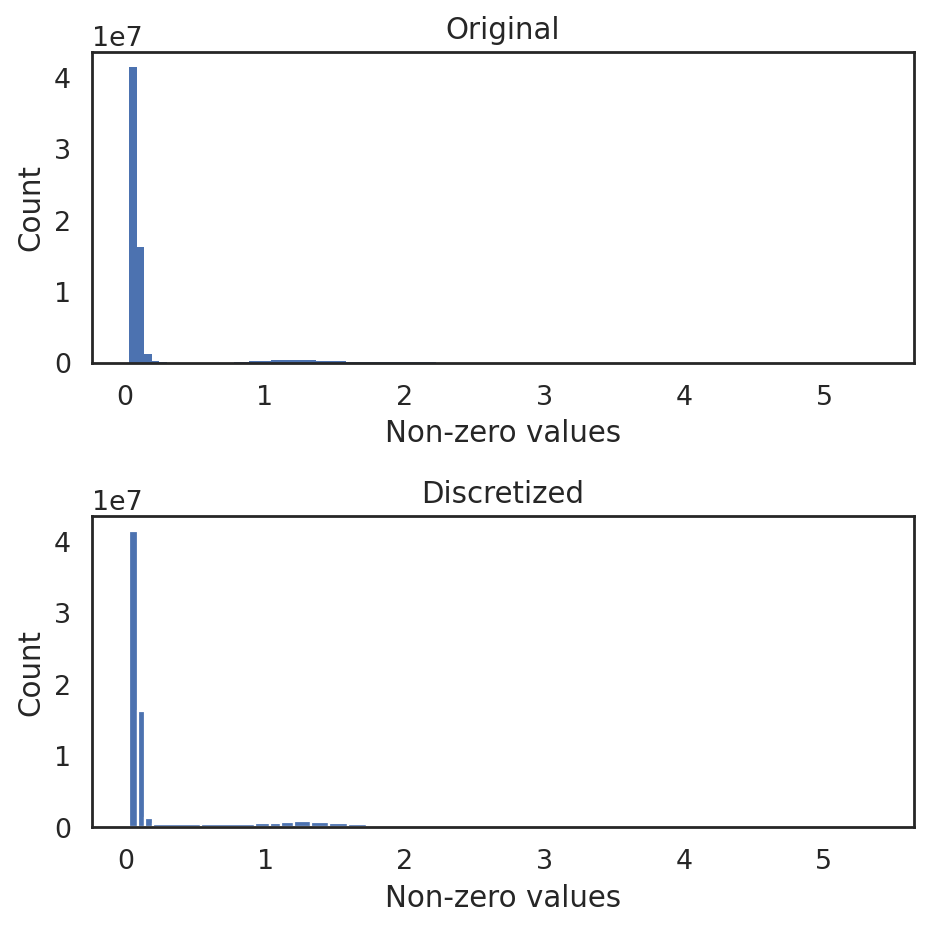

In [17]:
si.tl.discretize(banksy_local_adata,n_bins=20)
si.pl.discretize(banksy_local_adata,kde=False)

In [18]:
banksy_local_adata.var.gene_rank.value_counts()

gene_rank
-1    15818
 0    15818
 1    15818
 2    15818
 3    15818
 4    15818
 5    15818
 6    15818
 7    15818
 8    15818
 9    15818
Name: count, dtype: int64

In [19]:
si.tl.gen_graph(
    list_CG=[banksy_local_adata],
    layer='simba',
    use_highly_variable=False, 
    dirname='graph_local'
)

relation0: source: C, destination: G
#edges: 41485929
relation1: source: C, destination: G
#edges: 16203317
relation2: source: C, destination: G
#edges: 1249174
relation3: source: C, destination: G
#edges: 373358
relation4: source: C, destination: G
#edges: 418070
relation5: source: C, destination: G
#edges: 574657
relation6: source: C, destination: G
#edges: 582885
relation7: source: C, destination: G
#edges: 672799
relation8: source: C, destination: G
#edges: 773258
relation9: source: C, destination: G
#edges: 731287
relation10: source: C, destination: G
#edges: 531806
relation11: source: C, destination: G
#edges: 447867
relation12: source: C, destination: G
#edges: 303851
relation13: source: C, destination: G
#edges: 252291
relation14: source: C, destination: G
#edges: 266205
relation15: source: C, destination: G
#edges: 200714
relation16: source: C, destination: G
#edges: 103760
relation17: source: C, destination: G
#edges: 33694
relation18: source: C, destination: G
#edges: 20199


In [20]:
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model_local')

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.000362
Weight decay being used for training is 0.000362
Converting input data ...
[2025-03-06 01:32:23.337458] Using the 20 relation types given in the config
[2025-03-06 01:32:23.337944] Searching for the entities in the edge files...
[2025-03-06 01:33:40.113242] Entity type C:
[2025-03-06 01:33:40.114544] - Found 4221 entities
[2025-03-06 01:33:40.114853] - Removing the ones with fewer than 1 occurrences...
[2025-03-06 01:33:40.115687] - Left with 4221 entities
[2025-03-06 01:33:40.115969] - Shuffling them...
[2025-03-06 01:33:40.118081] Entity type G:
[2025-03-06 01:33:40.118357] - Found 173998 entities
[2025-03-06 01:33:40.118630] - Removing the ones with fewer than 1 occurrences...
[2025-03-06 01:33:40.143739] - Left with 173998 entities
[2025-03-06 01:33:40.144120] - Shuffling them...
[2025-03-06 01:33:40.238914] Preparing counts and dictionaries for entities and relation types:
[2025-03-06 01:33:

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:


[2025-03-06 01:39:20.961476] - Processed 65243987 edges in total
Starting training ...


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/c

Finished


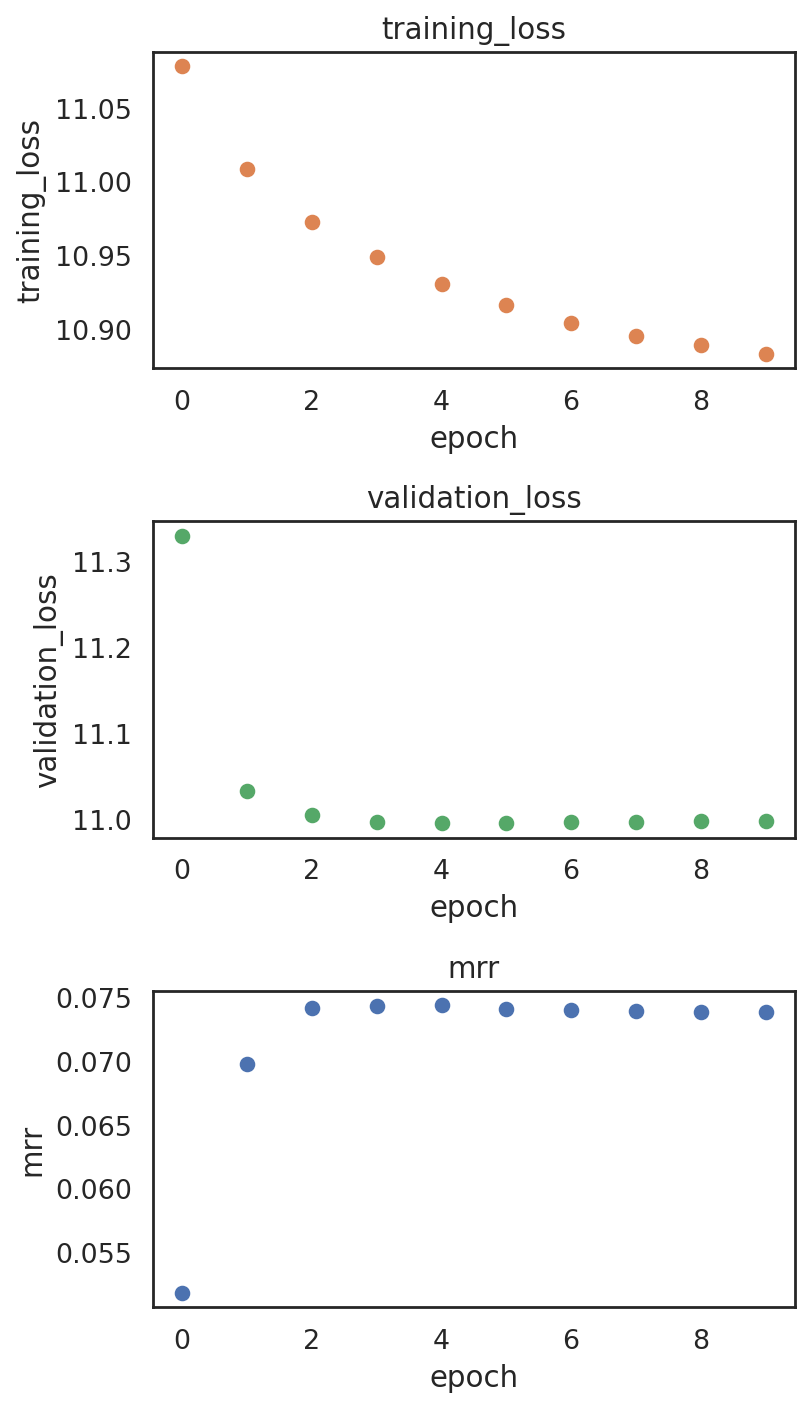

In [21]:
si.pl.pbg_metrics(fig_ncol=1)

In [22]:
# read in entity embeddings obtained from pbg training.
local_dict_adata = si.read_embedding()
local_dict_adata

{'G': AnnData object with n_obs × n_vars = 173998 × 50,
 'C': AnnData object with n_obs × n_vars = 4221 × 50}

In [23]:
local_adata_C = local_dict_adata['C']  # embeddings of cells
local_adata_G = local_dict_adata['G']  # embeddings of cells
local_adata_C.obs['spatialLIBD'] = adata[local_adata_C.obs_names,:].obs['spatialLIBD'].copy()
# nonly_adata_C.obs['n_counts'] = adata[nonly_adata_C.obs_names,:].obs['n_counts'].copy()
# nonly_adata_C.obs['n_genes'] = adata[nonly_adata_C.obs_names,:].obs['n_genes'].copy()
local_adata_C

AnnData object with n_obs × n_vars = 4221 × 50
    obs: 'spatialLIBD'

In [24]:
from cluster import get_pairwise_distance
from sklearn.metrics import silhouette_score

In [26]:
dists = get_pairwise_distance(local_adata_C.X) # on the data in X
sil = silhouette_score(X=dists, labels=local_adata_C.obs['spatialLIBD'])
sil

-0.006004254

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


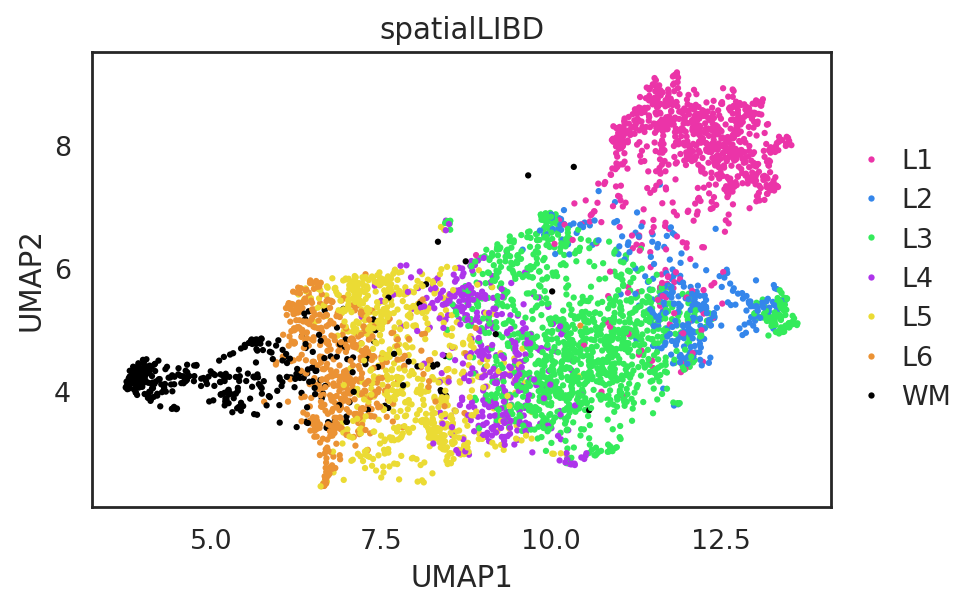

In [27]:
si.tl.umap(local_adata_C,n_neighbors=15,n_components=2)
si.pl.umap(
    local_adata_C,color=['spatialLIBD'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

# Global

In [28]:
banksy_global_adata, lambda_val, kn_weight = combine_adatas(adata, rankK_adatas, lambda_val=0.2)
kn_weight

0.08944271909999159

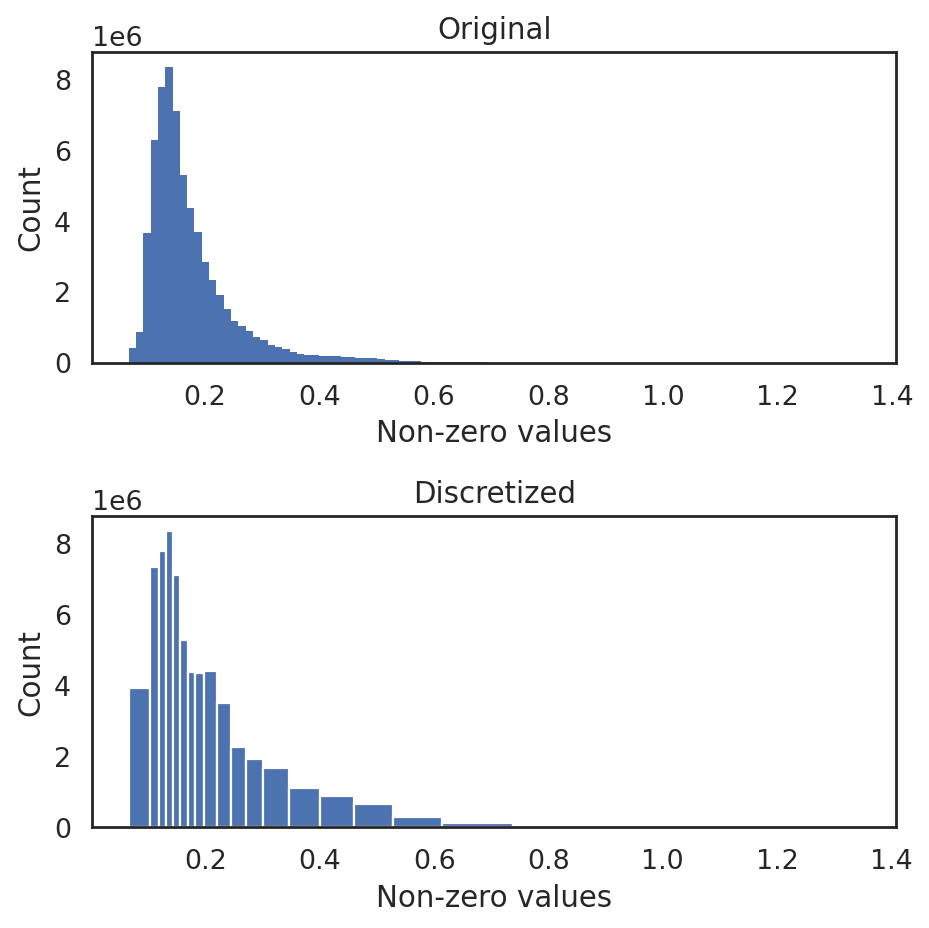

In [29]:
si.tl.discretize(banksy_global_adata,n_bins=20)
si.pl.discretize(banksy_global_adata,kde=False)

In [30]:
si.tl.gen_graph(
    list_CG=[banksy_global_adata],
    layer='simba',
    use_highly_variable=False, 
    dirname='graph_global'
)

relation0: source: C, destination: G
#edges: 3910098
relation1: source: C, destination: G
#edges: 7334981
relation2: source: C, destination: G
#edges: 7764193
relation3: source: C, destination: G
#edges: 8348579
relation4: source: C, destination: G
#edges: 7108224
relation5: source: C, destination: G
#edges: 5280546
relation6: source: C, destination: G
#edges: 4361428
relation7: source: C, destination: G
#edges: 4332954
relation8: source: C, destination: G
#edges: 4408378
relation9: source: C, destination: G
#edges: 3485594
relation10: source: C, destination: G
#edges: 2243234
relation11: source: C, destination: G
#edges: 1918074
relation12: source: C, destination: G
#edges: 1661389
relation13: source: C, destination: G
#edges: 1098592
relation14: source: C, destination: G
#edges: 865634
relation15: source: C, destination: G
#edges: 652475
relation16: source: C, destination: G
#edges: 282247
relation17: source: C, destination: G
#edges: 125469
relation18: source: C, destination: G
#edg

In [31]:
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model_global')

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.000362
Weight decay being used for training is 0.000362
Converting input data ...
[2025-03-06 03:00:48.953194] Using the 20 relation types given in the config
[2025-03-06 03:00:48.953708] Searching for the entities in the edge files...
[2025-03-06 03:02:05.829527] Entity type C:
[2025-03-06 03:02:05.830859] - Found 4221 entities
[2025-03-06 03:02:05.831177] - Removing the ones with fewer than 1 occurrences...
[2025-03-06 03:02:05.832089] - Left with 4221 entities
[2025-03-06 03:02:05.832390] - Shuffling them...
[2025-03-06 03:02:05.834502] Entity type G:
[2025-03-06 03:02:05.834784] - Found 173998 entities
[2025-03-06 03:02:05.835055] - Removing the ones with fewer than 1 occurrences...
[2025-03-06 03:02:05.860810] - Left with 173998 entities
[2025-03-06 03:02:05.861185] - Shuffling them...
[2025-03-06 03:02:05.955402] Preparing counts and dictionaries for entities and relation types:
[2025-03-06 03:02:

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/c

Finished


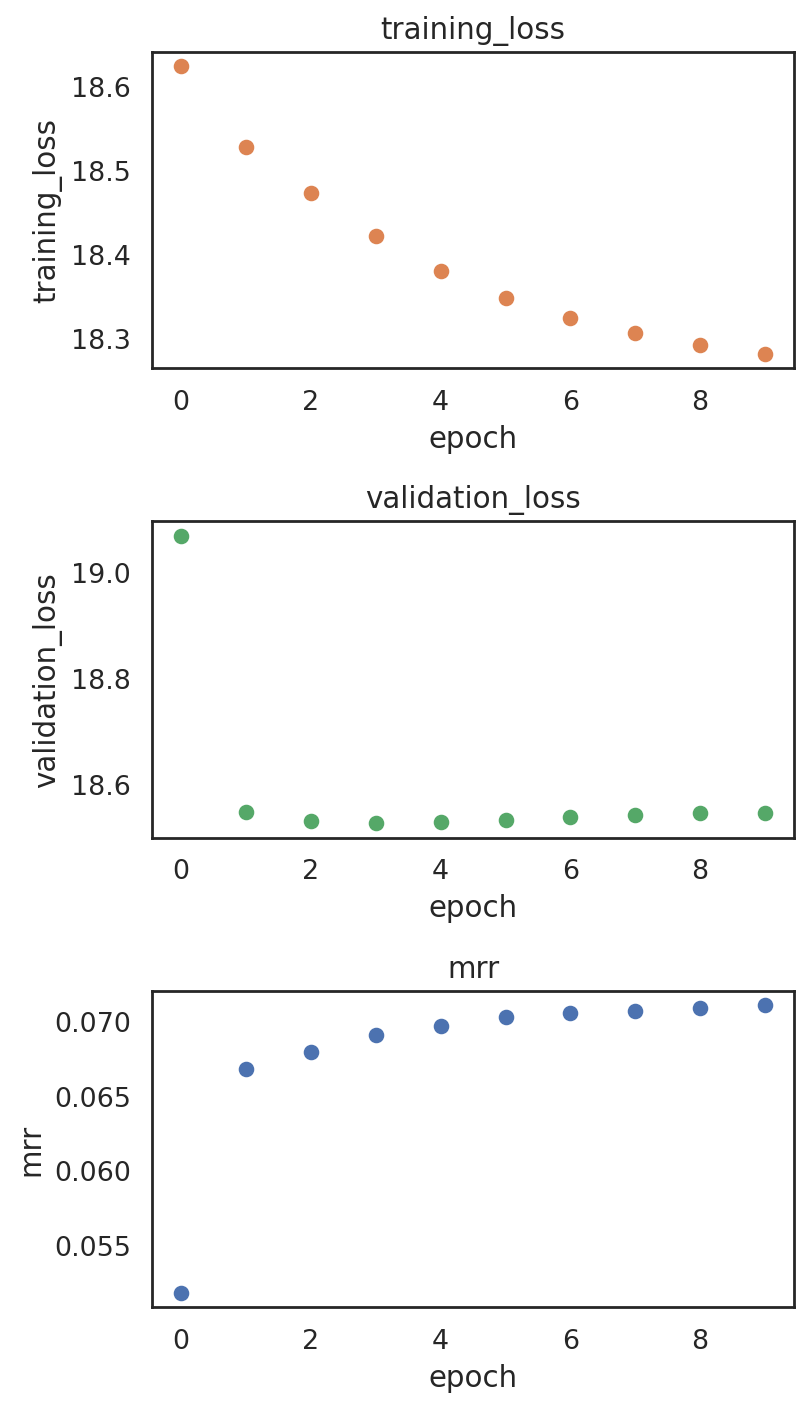

In [32]:
si.pl.pbg_metrics(fig_ncol=1)

In [36]:
# read in entity embeddings obtained from pbg training.
global_dict_adata = si.read_embedding()
global_dict_adata

{'G': AnnData object with n_obs × n_vars = 173998 × 50,
 'C': AnnData object with n_obs × n_vars = 4221 × 50}

In [37]:
global_adata_C = global_dict_adata['C']  # embeddings of cells
global_adata_G = global_dict_adata['G']  # embeddings of cells
global_adata_C.obs['spatialLIBD'] = adata[global_adata_C.obs_names,:].obs['spatialLIBD'].copy()
# nonly_adata_C.obs['n_counts'] = adata[nonly_adata_C.obs_names,:].obs['n_counts'].copy()
# nonly_adata_C.obs['n_genes'] = adata[nonly_adata_C.obs_names,:].obs['n_genes'].copy()
global_adata_C

AnnData object with n_obs × n_vars = 4221 × 50
    obs: 'spatialLIBD'

/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/cc_envs/cc_mamba_simba/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


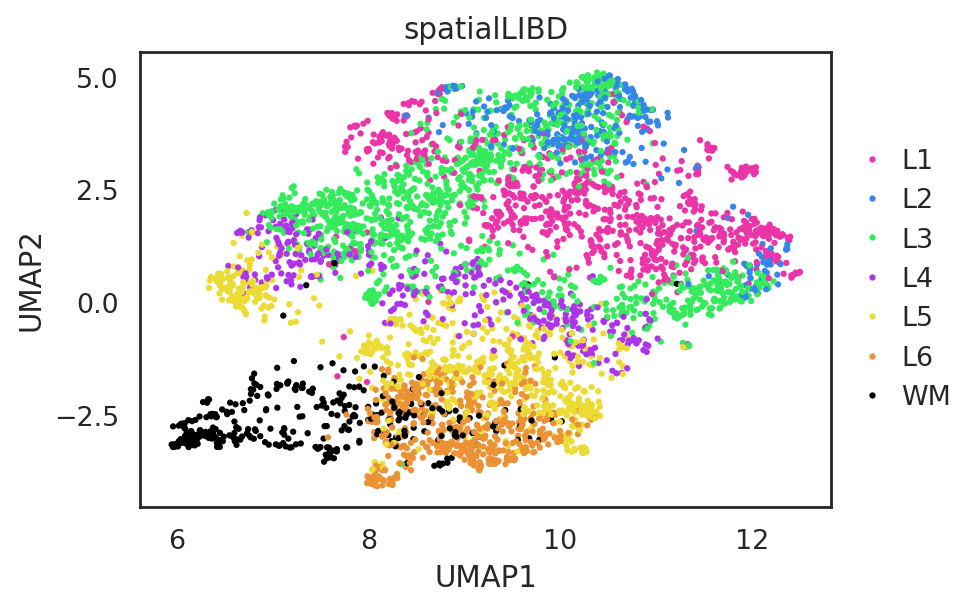

In [38]:
si.tl.umap(global_adata_C,n_neighbors=15,n_components=2)
si.pl.umap(
    global_adata_C,color=['spatialLIBD'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

In [39]:
dists = get_pairwise_distance(global_adata_C.X) # on the data in X
sil = silhouette_score(X=dists, labels=global_adata_C.obs['spatialLIBD'])
sil

-0.0294576